In [103]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

import joblib
import pickle

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
train_df = pd.read_csv("../data/train.csv", date_parser="Date", dtype={"StateHoliday" : str})
store = pd.read_csv("../data/store.csv")

In [3]:
train_df = train_df[train_df['Open']==1].copy()

In [4]:
train_df = train_df.merge(
    store,
    how="left",
    on = "Store",
)

In [5]:
print(len(train_df))
train_df.head()

844392


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
train_df.isnull().mean()

Store                        0.000000
DayOfWeek                    0.000000
Date                         0.000000
Sales                        0.000000
Customers                    0.000000
Open                         0.000000
Promo                        0.000000
StateHoliday                 0.000000
SchoolHoliday                0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002589
CompetitionOpenSinceMonth    0.318121
CompetitionOpenSinceYear     0.318121
Promo2                       0.000000
Promo2SinceWeek              0.501316
Promo2SinceYear              0.501316
PromoInterval                0.501316
dtype: float64

In [7]:
def split_date(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df['Year'] = df.Date.dt.year
  df['Month'] = df.Date.dt.month
  df['Day'] = df.Date.dt.day
  df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [8]:
split_date(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


In [9]:
def comp_months(df):
  df['CompetitionAge'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
  df['CompetitionAge'] = df['CompetitionAge'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [10]:
comp_months(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionAge
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0


In [11]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Age'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Age'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Age'] = df['Promo2Age'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Applied'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [12]:
promo_cols(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionAge,Promo2Age,IsPromo2Applied
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,31,31,82.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.131148,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,51.901639,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,31,31,70.0,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,NaN,NaN,NaN,2015,7,31,31,3.0,0.000000,0


In [13]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionAge', 'Promo2Age', 'IsPromo2Applied'],
      dtype='object')

In [14]:
# train_df.to_csv("../data/train_new.csv", index=False)

In [15]:
features = ['Store', 'DayOfWeek', 'Day', 'Month', 'WeekOfYear', 'Year', 'Promo', 'StateHoliday', \
    'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionAge', \
    'IsPromo2Applied', 'Promo2', 'Promo2Age',
]

numeric_feats = ['Store', 'Day', 'Month', 'Year', 'WeekOfYear', 'Promo', 'SchoolHoliday', 'CompetitionDistance', \
    'CompetitionAge', 'IsPromo2Applied', 'Promo2', 'Promo2Age', 
]

categorical_feats = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

In [16]:
inputs = train_df[features].copy()
target = train_df['Sales'].copy()

## 2. Modelisation

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    inputs, target, test_size=1/3, random_state=12
)

print("Training data length : ", len(X_train))
print("Test data length : ", len(X_test))

Training data length :  562928
Test data length :  281464


### 2.1. Preprocessing

#### 2.1.1. Missing Values

In [77]:
X_train[numeric_feats].isna().sum()

Store                     0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
Promo                     0
SchoolHoliday             0
CompetitionDistance    1478
CompetitionAge            0
IsPromo2Applied           0
Promo2                    0
Promo2Age                 0
dtype: int64

In [78]:
X_test[numeric_feats].isna().sum()

Store                    0
Day                      0
Month                    0
Year                     0
WeekOfYear               0
Promo                    0
SchoolHoliday            0
CompetitionDistance    708
CompetitionAge           0
IsPromo2Applied          0
Promo2                   0
Promo2Age                0
dtype: int64

In [79]:
max_distance = X_train.CompetitionDistance.max()
max_distance

75860.0

In [80]:
X_train['CompetitionDistance'].fillna(max_distance * 10, inplace=True)
X_test['CompetitionDistance'].fillna(max_distance * 10, inplace=True)

/Users/kevinab/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [81]:
X_train[numeric_feats].isna().sum()

Store                  0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionAge         0
IsPromo2Applied        0
Promo2                 0
Promo2Age              0
dtype: int64

In [82]:
X_test[numeric_feats].isna().sum()

Store                  0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionAge         0
IsPromo2Applied        0
Promo2                 0
Promo2Age              0
dtype: int64

### 2.2. Pipeline

In [92]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=300,
                    learning_rate=0.3, max_depth=10, subsample=0.9,
                    colsample_bytree=0.7
)
                    
preprocessor = ColumnTransformer([
    ("scaler", MinMaxScaler(), numeric_feats),
    ("encoder", OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_feats)
])

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])

In [93]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['Store', 'Day', 'Month',
                                                   'Year', 'WeekOfYear',
                                                   'Promo', 'SchoolHoliday',
                                                   'CompetitionDistance',
                                                   'CompetitionAge',
                                                   'IsPromo2Applied', 'Promo2',
                                                   'Promo2Age']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['DayOfWeek', 'StateHoliday',
                                                   'StoreType',
   

In [98]:
encoded_cols = list(pipe.named_steps["preprocessor"].named_transformers_["encoder"].get_feature_names(categorical_feats))
columns = numeric_feats + encoded_cols

In [156]:
rmse_test = mean_squared_error(y_test, pipe.predict(X_test) ,squared=False)
rmse_test

719.9272769667343

In [96]:
mean_squared_error(y_train, pipe.predict(X_train) ,squared=False)

500.20080546914994

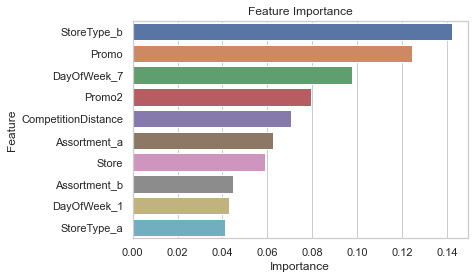

In [100]:
importance_df = pd.DataFrame({
    'feature': columns,
    'importance': pipe.named_steps["model"].feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature');

In [113]:
joblib.dump(pipe, '../model/pipeline.pkl')

['../model/pipeline.pkl']

In [114]:
pipeline = joblib.load('../model/pipeline.pkl')

In [116]:
mean_squared_error(y_test, pipeline.predict(X_test) ,squared=False)

719.9272769667343

## Interpretation de la performance du modèle

In [146]:
test = pd.concat([X_test, y_test], axis=1)
df_1 = test.loc[train_df['Store'] == 1]

In [147]:
df_1_pred_sales = pipeline.predict(df_1[features])

In [148]:
def getDate(row):
    row["Date"] = dt.date(row.Year, row.Month, row.Day)
    return row

df_1 = df_1.apply(getDate, axis=1)
df_1["pred_Sales"] = df_1_pred_sales

No handles with labels found to put in legend.


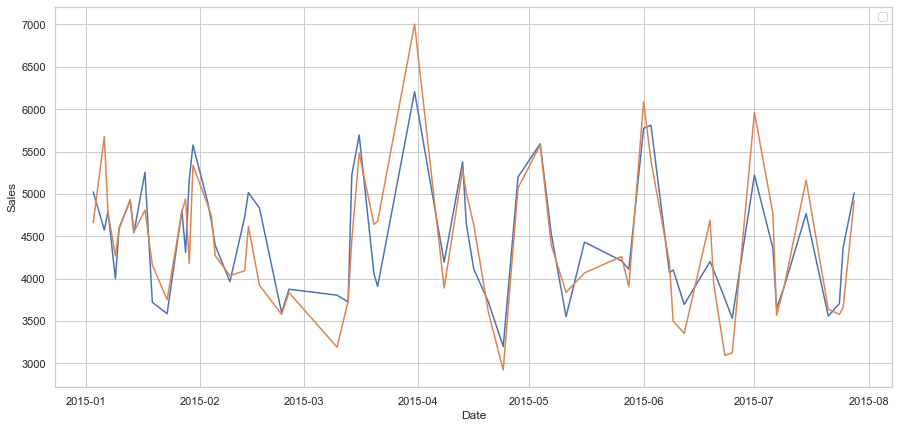

In [155]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_1.loc[df_1['Date'] >= dt.date(2015,1,1)], x='Date', y='Sales')
sns.lineplot(data=df_1.loc[df_1['Date'] >= dt.date(2015,1,1)], x='Date', y='pred_Sales')
plt.legend()